In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, MaxPooling1D, Input, Conv1D, BatchNormalization
from tensorflow.keras import utils
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization


In [2]:
mb_df = pd.read_csv('../../../large-data/mbti_1.csv')

In [3]:
mb_df.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [4]:
# Source: https://www.kaggle.com/anasofiauzsoy/myers-briggs-types-with-tensorflow-bert

import string
import re

def clean_text(text):
    regex = re.compile('[%s]' % re.escape('|'))
    text = regex.sub(" ", text)
    words = str(text).split()
    words = [i.lower() + " " for i in words]
    words = [i for i in words if not "http" in i]
    words = " ".join(words)
    words = words.translate(words.maketrans('', '', string.punctuation))
    return words

In [5]:
mb_df['clean_text'] = mb_df['posts'].apply(clean_text)

In [6]:
mb_df['type_factorized'], names = pd.factorize(mb_df['type'])

In [7]:
mb_df.head()

,type,posts,clean_text,type_factorized
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,enfp and intj moments sportscenter not t...,0
1,ENTP,'I'm finding the lack of me in these posts ver...,im finding the lack of me in these pos...,1
2,INTP,'Good one _____ https://www.youtube.com/wat...,good one of course to which i say i ...,2
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",dear intp i enjoyed our conversation the...,3
4,ENTJ,'You're fired.|||That's another silly misconce...,youre fired thats another silly misconcep...,4


In [8]:
X = mb_df['clean_text']
y = mb_df['type_factorized']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=22)

In [9]:
tfvect = TfidfVectorizer(max_features=500)

In [10]:
X_train_vect = tfvect.fit_transform(X_train)
X_test_vect = tfvect.transform(X_test)

In [11]:
X_train_vect = X_train_vect.toarray()
X_test_vect = X_test_vect.toarray()

In [12]:
y_train_cat = utils.to_categorical(y_train, num_classes=16)
y_test_cat = utils.to_categorical(y_test, num_classes=16)

In [13]:
X_train_vect.shape

(6506, 500)

In [14]:
X_test_vect.shape

(2169, 500)

In [15]:
model = Sequential()

model.add(Input(shape=(500, )))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.4))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.4))
model.add(Dense(16, activation = 'softmax'))
model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy', 'Recall'])

In [16]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [17]:
history = model.fit(X_train_vect,
                    y_train_cat,
                    validation_data=(X_test_vect, y_test_cat),
                    callbacks = callback,
                    epochs=30)

Epoch 1/30
204/204 [==============================] - 0s 2ms/step - loss: 2.3153 - accuracy: 0.2169 - recall: 3.0741e-04 - val_loss: 2.1604 - val_accuracy: 0.3292 - val_recall: 0.0000e+00
Epoch 2/30
204/204 [==============================] - 0s 1ms/step - loss: 2.0243 - accuracy: 0.3538 - recall: 0.0424 - val_loss: 1.7884 - val_accuracy: 0.4735 - val_recall: 0.1130
Epoch 3/30
204/204 [==============================] - 0s 1ms/step - loss: 1.7003 - accuracy: 0.4889 - recall: 0.2037 - val_loss: 1.5370 - val_accuracy: 0.5408 - val_recall: 0.3260
Epoch 4/30
204/204 [==============================] - 0s 1ms/step - loss: 1.5049 - accuracy: 0.5544 - recall: 0.3328 - val_loss: 1.4301 - val_accuracy: 0.5758 - val_recall: 0.3974
Epoch 5/30
204/204 [==============================] - 0s 1ms/step - loss: 1.3989 - accuracy: 0.5855 - recall: 0.3992 - val_loss: 1.4113 - val_accuracy: 0.5841 - val_recall: 0.4283
Epoch 6/30
204/204 [==============================] - 0s 1ms/step - loss: 1.3127 - accuracy:

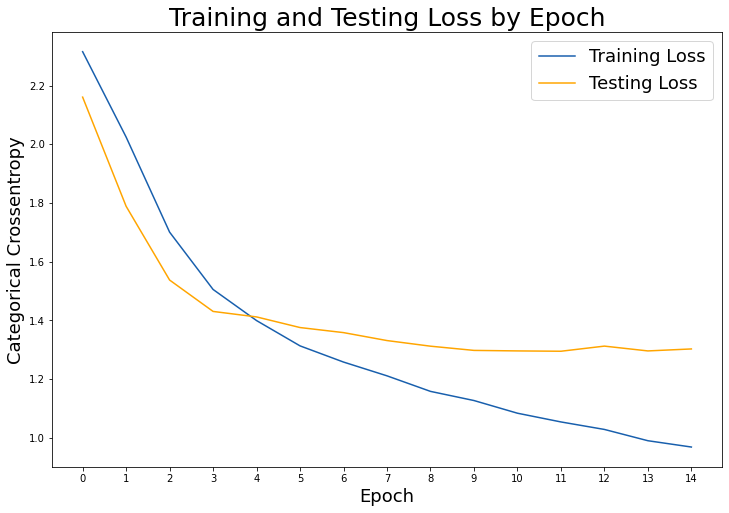

In [18]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']
epoch_labels = history.epoch

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize=25)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Categorical Crossentropy', fontsize=18)
plt.xticks(epoch_labels, epoch_labels)    # ticks, labels

plt.legend(fontsize=18);

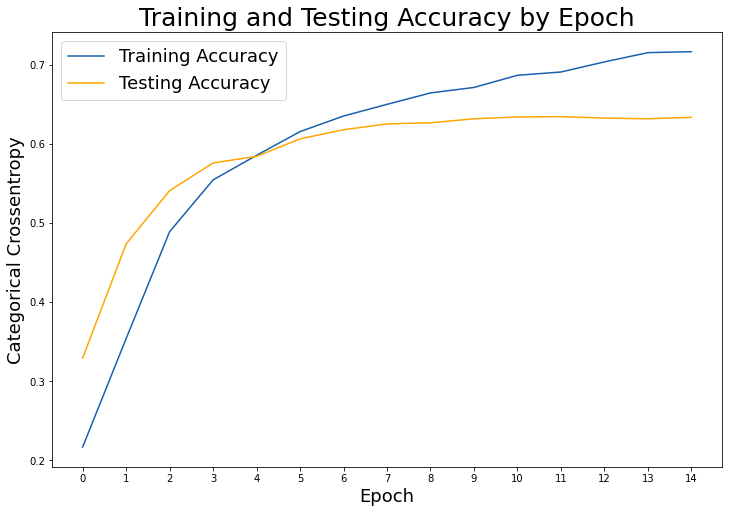

In [19]:
train_acc = history.history['accuracy']
test_acc = history.history['val_accuracy']
epoch_labels = history.epoch

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_acc, label='Training Accuracy', color='#185fad')
plt.plot(test_acc, label='Testing Accuracy', color='orange')

# Set title
plt.title('Training and Testing Accuracy by Epoch', fontsize=25)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Categorical Crossentropy', fontsize=18)
plt.xticks(epoch_labels, epoch_labels)    # ticks, labels

plt.legend(fontsize=18);

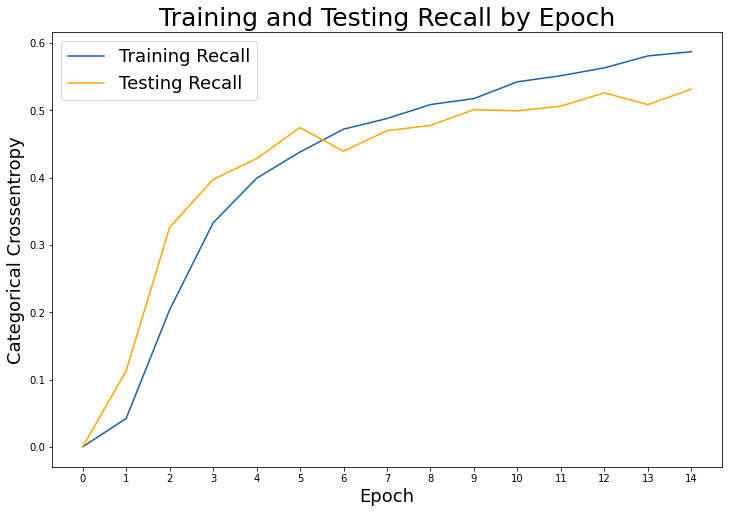

In [20]:
train_rec = history.history['recall']
test_rec = history.history['val_recall']
epoch_labels = history.epoch

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_rec, label='Training Recall', color='#185fad')
plt.plot(test_rec, label='Testing Recall', color='orange')

# Set title
plt.title('Training and Testing Recall by Epoch', fontsize=25)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Categorical Crossentropy', fontsize=18)
plt.xticks(epoch_labels, epoch_labels)    # ticks, labels

plt.legend(fontsize=18);

In [21]:
preds = model.predict_classes(X_test_vect)
preds

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([2, 6, 0, ..., 1, 2, 7])

In [22]:
preds.shape

(2169,)

In [23]:
y_test.shape

(2169,)

In [24]:
tf.math.confusion_matrix(y_test, predictions=preds)

<tf.Tensor: shape=(16, 16), dtype=int32, numpy=
array([[267,   5,  16,  20,   2,   0,  41,  12,   0,   2,   2,   1,   0,
          0,   0,   0],
       [ 18,  89,  35,  12,   0,   0,   5,  10,   0,   0,   1,   1,   0,
          0,   0,   0],
       [ 14,  10, 251,  19,   2,   0,  18,   1,   2,   7,   1,   1,   0,
          0,   0,   0],
       [ 25,  11,  27, 172,  12,   0,  11,   7,   2,   2,   2,   2,   0,
          0,   0,   0],
       [  5,  11,   5,   7,  26,   0,   3,   0,   1,   0,   0,   0,   0,
          0,   0,   0],
       [ 15,   0,   2,   1,   0,  10,  11,   4,   3,   0,   1,   1,   0,
          0,   0,   0],
       [ 41,   6,  22,  20,   1,   2, 343,  13,   4,   1,   2,   3,   0,
          0,   0,   0],
       [ 16,   6,   7,  11,   3,   4,  15, 103,   2,   1,   0,   1,   0,
          0,   0,   0],
       [ 12,   2,   5,   1,   2,   0,   7,   3,  29,   4,   2,   0,   1,
          0,   0,   0],
       [  5,   2,  12,   2,   1,   0,   6,   3,   2,  50,   0,   0,   1,
      

In [25]:
import tensorboard
import datetime

In [26]:
%reload_ext tensorboard

In [27]:
logdir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")


In [28]:
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)


In [29]:
history = model.fit(X_train_vect,
                    y_train_cat,
                    validation_data=(X_test_vect, y_test_cat),
                    callbacks = [tb_callback],
                    epochs=15)

Epoch 1/15
  1/204 [..............................] - ETA: 0s - loss: 0.6719 - accuracy: 0.8438 - recall: 0.7500WARNING:tensorflow:From /Users/claireph/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
204/204 [==============================] - 0s 2ms/step - loss: 0.9510 - accuracy: 0.7250 - recall: 0.5944 - val_loss: 1.3185 - val_accuracy: 0.6289 - val_recall: 0.5325
Epoch 2/15
204/204 [==============================] - 0s 1ms/step - loss: 0.9192 - accuracy: 0.7362 - recall: 0.6104 - val_loss: 1.3103 - val_accuracy: 0.6293 - val_recall: 0.5390
Epoch 3/15
204/204 [==============================] - 0s 1ms/step - loss: 0.8921 - accuracy: 0.7395 - recall: 0.6193 - val_loss: 1.3428 - val_accuracy: 0.6261 - val_recall: 0.5440
Epoch 4/15
204/204 [==============================] - 0s 1ms/s

In [30]:
%tensorboard --logdir logs/fit